In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

load_df    = pd.read_csv('/content/load_data.csv')
weather_df = pd.read_csv('/content/weather_data.csv')



# 1. Load raw CSVs
load_df    = pd.read_csv('load_data.csv')
weather_df = pd.read_csv('weather_data.csv')

# 2. Identify and Impute Nulls in Load Data
hour_cols = [f'h{i}' for i in range(1, 25)]
for col in hour_cols:
    median_val = load_df[col].median()
    load_df[col].fillna(median_val, inplace=True)

# 3. Identify and Impute Nulls in Weather Data
weather_df.sort_values(['station_id','year','month','day'], inplace=True)
for col in hour_cols:
    # forward fill then backward fill per station
    weather_df[col] = weather_df.groupby('station_id')[col].transform(lambda grp: grp.ffill().bfill())

# 4. Outlier Treatment via Winsorization (1st and 99th percentiles)
def winsorize(df, cols, lower_pct=0.01, upper_pct=0.99):
    for col in cols:
        lower, upper = df[col].quantile([lower_pct, upper_pct])
        df[col] = df[col].clip(lower, upper)
    return df

load_df    = winsorize(load_df,    hour_cols)
weather_df = winsorize(weather_df, hour_cols)

# 5. Reshape Wide to Long and Parse Timestamps
def to_long(df, id_cols, value_name):
    hours = [f'h{i}' for i in range(1,25)]
    df_long = df.melt(id_vars=id_cols, value_vars=hours,
                      var_name='hour', value_name=value_name)
    df_long['hour'] = df_long['hour'].str.extract(r'h(\d+)').astype(int) - 1
    df_long['timestamp'] = pd.to_datetime(df_long[['year','month','day']]) + \
                           pd.to_timedelta(df_long['hour'], unit='h')
    return df_long[['timestamp', value_name]]

load_long    = to_long(load_df,    ['zone_id','year','month','day'], 'load')
weather_long = to_long(weather_df, ['station_id','year','month','day'], 'temp')


data = pd.merge(load_long, weather_long, on='timestamp', how='inner').sort_values('timestamp')
data.reset_index(drop=True, inplace=True)

data['hour']      = data['timestamp'].dt.hour
data['dayofweek'] = data['timestamp'].dt.dayofweek
data['month']     = data['timestamp'].dt.month
data['is_weekend']= data['dayofweek'].isin([5,6]).astype(int)
data['load_24h_avg'] = data['load'].rolling(24).mean()
data['temp_24h_avg'] = data['temp'].rolling(24).mean()


In [36]:
weather_long.isnull().sum()

,0
timestamp,0
temp,0


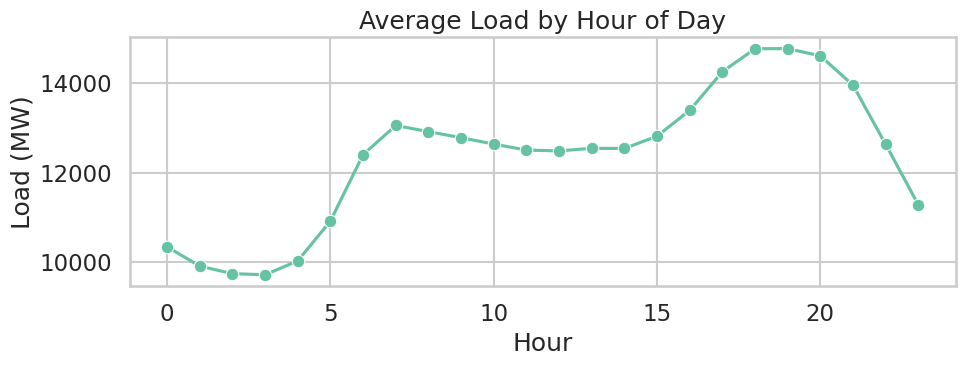

In [29]:
plt.figure(figsize=(10,4))
sns.lineplot(data=data.groupby('hour')['load'].mean().reset_index(),
             x='hour', y='load', marker='o')
plt.title('Average Load by Hour of Day')
plt.xlabel('Hour'); plt.ylabel('Load (MW)')
plt.tight_layout(); plt.show()



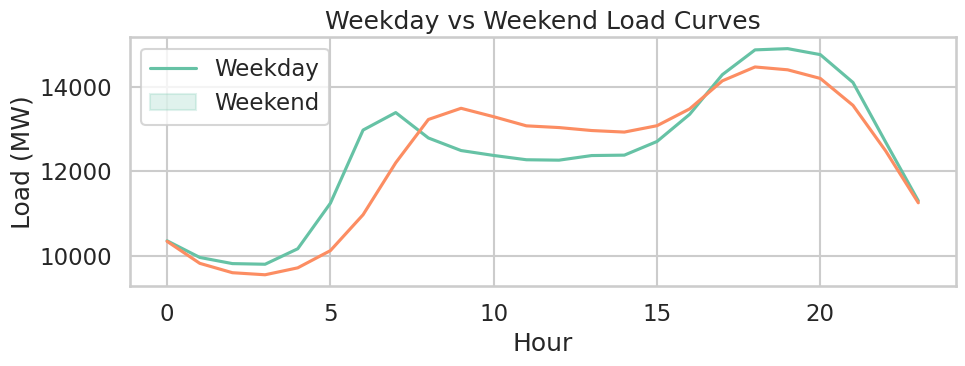

In [30]:
# Weekday vs Weekend
plt.figure(figsize=(10,4))
sns.lineplot(data=data.groupby(['hour','is_weekend'])['load'].mean().reset_index(),
             x='hour', y='load', hue='is_weekend', palette=['C0','C1'])
plt.title('Weekday vs Weekend Load Curves')
plt.xlabel('Hour'); plt.ylabel('Load (MW)')
plt.legend(['Weekday','Weekend'])
plt.tight_layout(); plt.show()



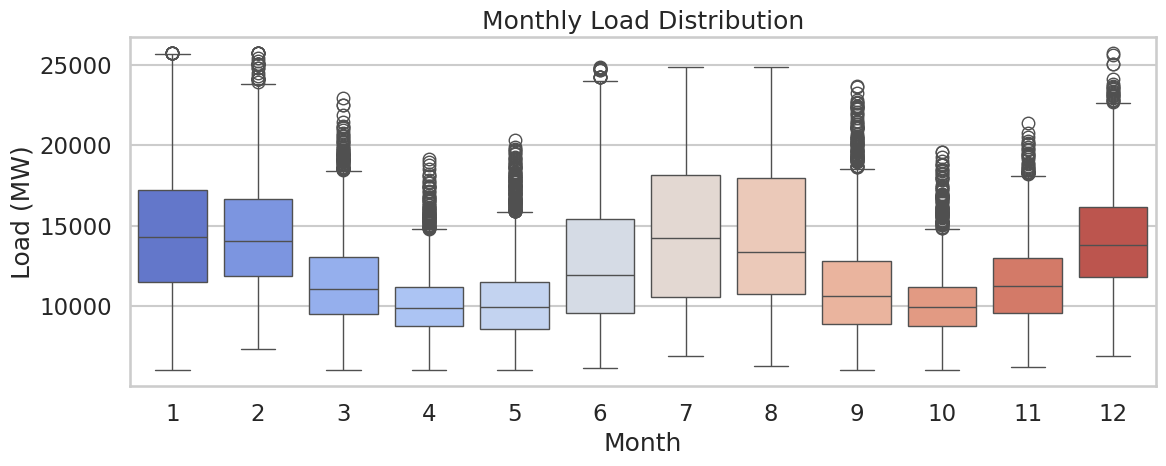

In [31]:
plt.figure(figsize=(12,5))
sns.boxplot(data=data, x='month', y='load', palette='coolwarm')
plt.title('Monthly Load Distribution')
plt.xlabel('Month'); plt.ylabel('Load (MW)')
plt.tight_layout(); plt.show()



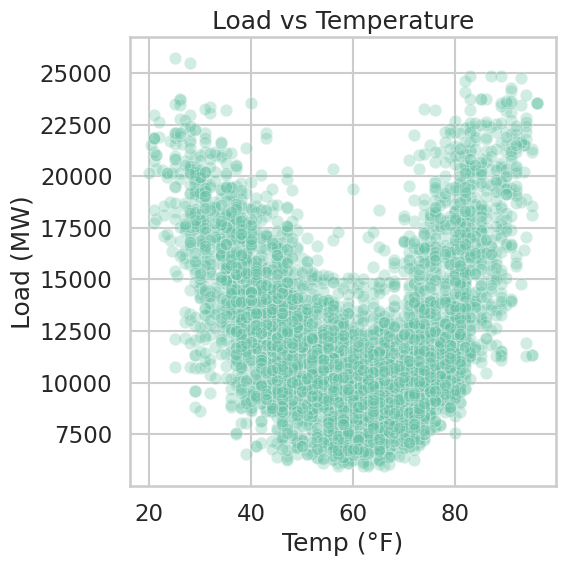

In [32]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=data.sample(5000, random_state=42),
                x='temp', y='load', alpha=0.3)
plt.title('Load vs Temperature')
plt.xlabel('Temp (°F)'); plt.ylabel('Load (MW)')
plt.tight_layout(); plt.show()



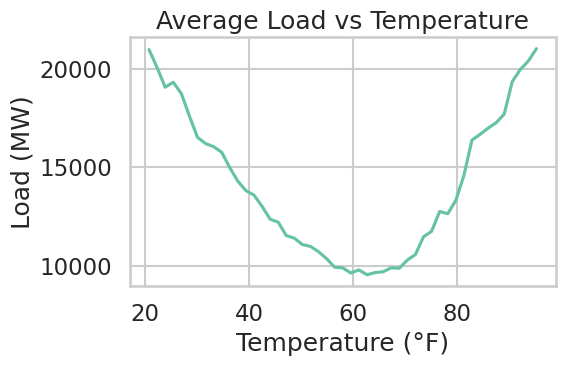

In [33]:
temp_bins = np.linspace(data['temp'].min(), data['temp'].max(), 50)
data['temp_bin'] = pd.cut(data['temp'], temp_bins)
load_by_temp = data.groupby('temp_bin')['load'].mean().reset_index()
load_by_temp['temp_mid'] = load_by_temp['temp_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(6,4))
sns.lineplot(x='temp_mid', y='load', data=load_by_temp)
plt.title('Average Load vs Temperature')
plt.xlabel('Temperature (°F)'); plt.ylabel('Load (MW)')
plt.tight_layout(); plt.show()



Test MAE = 272.39 MW
Test RMSE = 378.87 MW


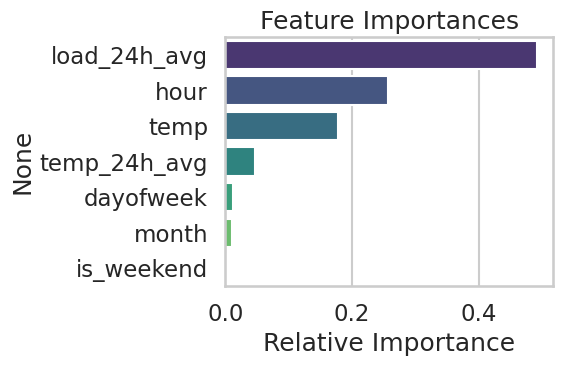

In [34]:
features = ['temp','hour','dayofweek','month','is_weekend','load_24h_avg','temp_24h_avg']
X = data[features]
y = data['load']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {'n_estimators':[100,200], 'max_depth':[10,20]}
grid = GridSearchCV(rf, param_grid, cv=tscv,
                    scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_scaled, y)
best_rf = grid.best_estimator_

# 7.4 Evaluation on last 20% hold-out
split = int(len(data)*0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
y_pred = best_rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE = {mae:.2f} MW")
print(f"Test RMSE = {rmse:.2f} MW")

# 8. Feature Importances
importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Relative Importance'); plt.tight_layout(); plt.show()

In [38]:


# 2. Monthly Average Load Line Plot
monthly = df.set_index('timestamp').resample('M')['load'].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x='timestamp', y='load', data=monthly, marker='o')
plt.title('Monthly Average Load Over Time')
plt.xlabel('Month'); plt.ylabel('Avg Load (MW)')
plt.tight_layout()
plt.show()

# 3. Heatmap: Hour of Day vs Day of Week
pivot = df.pivot_table(index='dayofweek', columns='hour', values='load', aggfunc='mean')
plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Load (MW)'})
plt.title('Average Load: Hour of Day vs Day of Week')
plt.xlabel('Hour'); plt.ylabel('Day of Week (0=Mon)')
plt.tight_layout()
plt.show()

# 4. Scatter with Regression: Load vs Cooling Degree Hours (CDH)
if 'CDH' in df.columns:
    plt.figure(figsize=(6,6))
    sns.regplot(x='CDH', y='load', data=df.sample(5000, random_state=1),
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Load vs Cooling Degree Hours')
    plt.xlabel('CDH (°F·h)'); plt.ylabel('Load (MW)')
    plt.tight_layout()
    plt.show()

# 5. Boxplot: Quarterly Load Distribution
df['quarter'] = df['timestamp'].dt.to_period('Q').astype(str)
plt.figure(figsize=(10,5))
sns.boxplot(x='quarter', y='load', data=df, palette='coolwarm')
plt.title('Load Distribution by Quarter')
plt.xlabel('Quarter'); plt.ylabel('Load (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Time Series Decomposition (optional)
from statsmodels.tsa.seasonal import seasonal_decompose
ts = df.set_index('timestamp')['load'].resample('H').mean().fillna(method='ffill')
decomp = seasonal_decompose(ts, model='additive', period=24)
plt.figure(figsize=(12,8))
decomp.plot()
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined